### Note some comments are made hidden so that i can rerun the whole jupyter without having troubles. 

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root_path = '/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration'

In [ ]:
# !unzip /content/drive/MyDrive/Colab\ Notebooks/CNN_assignment.zip -d /content/drive/MyDrive/Colab\ Notebooks/

In [4]:
batch_size = 32
img_height = 180
img_width = 180

In [5]:
train_generator = tf.keras.preprocessing.image_dataset_from_directory(f"{root_path}/Train",
                                                                    batch_size=32,
                                                                    image_size=(img_height, img_width),
                                                                      seed= 123,
                                                                      color_mode='rgb',
                                                                      label_mode = 'categorical'
                                                             )

Found 2239 files belonging to 9 classes.


In [6]:
test_generator = tf.keras.preprocessing.image_dataset_from_directory(f"{root_path}/Test",
                                                                    batch_size=32,
                                                                    image_size=(img_height, img_width),
                                                                      seed= 123,
                                                                     color_mode='rgb',
                                                                     label_mode = 'categorical'

                                                             )

Found 118 files belonging to 9 classes.


In [7]:
class_names = train_generator.class_names
n_classes = len(class_names)

print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [8]:
for class_name in class_names:
  print (f"{class_name},{len([name for name in os.listdir(f'{root_path}/Train/{class_name}')])}")

actinic keratosis,114
basal cell carcinoma,376
dermatofibroma,95
melanoma,438
nevus,357
pigmented benign keratosis,462
seborrheic keratosis,77
squamous cell carcinoma,181
vascular lesion,139


In [9]:
label_dist_normal = []
for class_name in class_names:
  label_dist_normal.append((class_name,len([name for name in os.listdir(f"{root_path}/Train/{class_name}")])))

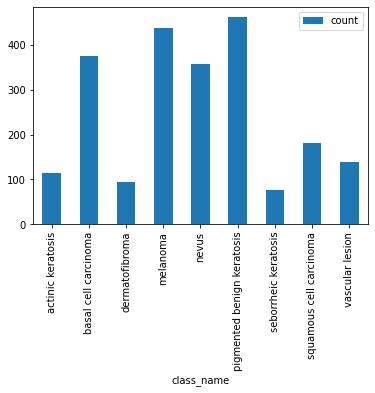

In [10]:
pd.DataFrame(label_dist_normal,columns=['class_name','count']).plot.bar(x='class_name', y='count')

### From the above EDA, we can see the classes are unbalancly distributed.
77 is the lowest number of class belonging to seborrheic keratosis and pigmented benign keratosis the highest with 462 images.

In [11]:
#STEPS_PER_EPOCH = pd.DataFrame(label_dist,columns=['class_name','count1']).count1.sum()//batch_size



In [12]:
# pd.DataFrame(label_dist,columns=['class_name','count1']).count1.sum() // batch_size

### Plotting one sample from each category

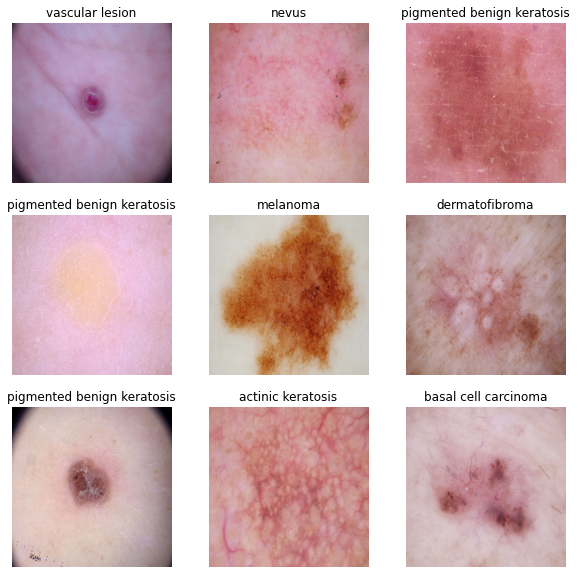

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_generator.take(1):
    for i in range(n_classes):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #print(np.argmax(labels[i]))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

In [14]:
for image_batch, labels_batch in train_generator:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32, 9)


In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = test_generator.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
# normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [17]:
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixels values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

### Rescaling image by dividing with 255

In [18]:
def get_model(num_classes=0):
  model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  
  layers.Conv2D(32, (3,3), padding='same', activation='relu',kernel_initializer='he_normal'),
  #layers.AveragePooling2D(pool_size=(2, 2)),
  
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.AveragePooling2D(pool_size=(2, 2)),
  
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  # layers.AveragePooling2D(pool_size=(2, 2)),

  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.AveragePooling2D(pool_size=(2, 2)),

  layers.Conv2D(128, (3,3), padding='same', activation='relu'),
  # layers.MaxPooling2D(pool_size=(2, 2)),

  layers.Conv2D(128, (3,3), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.AveragePooling2D(pool_size=(2, 2)),

  layers.Flatten(),
  layers.BatchNormalization(),
  layers.Dense(128, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dense(512, activation='relu'),
  
  layers.Dense(n_classes,activation='softmax')
  ])

  return model

In [19]:
model = get_model(n_classes)

In [20]:
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(min_lr=0.0001)
reduce_lr = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3,restore_best_weights=True)

In [21]:
optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [22]:
model.compile(optimizer=optimizer,#'rmsprop',tf.keras.optimizers.SGD(),
              loss='categorical_crossentropy',#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 32)      9248      
_________________________________________________________________
average_pooling2d (AveragePo (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 90, 90, 64)        36928     
_________________________________________________________________
average_pooling2d_1 (Average (None, 45, 45, 64)        0

In [24]:
STEPS_PER_EPOCH = int( np.ceil(pd.DataFrame(label_dist_normal,columns=['class_name','count1']).count1.sum() / batch_size) )
STEPS_PER_EPOCH

70

In [25]:
epochs = 50
history = model.fit(
  train_generator,
  validation_data=test_generator,
  epochs=epochs,
  #use_multiprocessing = True,
  steps_per_epoch = STEPS_PER_EPOCH,
  callbacks = [reduce_lr]
)

Epoch 1/50
70/70 [==============================] - 521s 7s/step - loss: 2.6049 - accuracy: 0.2772 - val_loss: 11.1094 - val_accuracy: 0.0847
Epoch 2/50
70/70 [==============================] - 29s 385ms/step - loss: 1.8224 - accuracy: 0.4018 - val_loss: 8.4058 - val_accuracy: 0.0932
Epoch 3/50
70/70 [==============================] - 29s 381ms/step - loss: 1.6149 - accuracy: 0.4464 - val_loss: 12.3229 - val_accuracy: 0.1356
Epoch 4/50
70/70 [==============================] - 29s 385ms/step - loss: 1.5123 - accuracy: 0.4731 - val_loss: 13.9681 - val_accuracy: 0.1102
Epoch 5/50
70/70 [==============================] - 29s 382ms/step - loss: 1.4537 - accuracy: 0.4891 - val_loss: 45.6607 - val_accuracy: 0.1610
Epoch 6/50
70/70 [==============================] - 30s 393ms/step - loss: 1.4090 - accuracy: 0.5242 - val_loss: 52.9508 - val_accuracy: 0.1271
Epoch 7/50
70/70 [==============================] - 29s 385ms/step - loss: 1.3538 - accuracy: 0.5249 - val_loss: 46.4793 - val_accuracy: 0.

In [28]:
def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(len(val_loss))

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

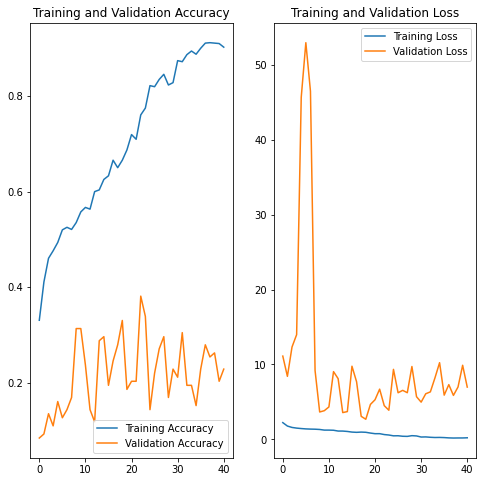

In [29]:
plot_history(history)

### From the above graph we can see it is clearly overfitting.
### Adding droupout and regularization


In [32]:
def get_model_dropouts(num_classes=0):
    model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  
  layers.Conv2D(32, (3,3), padding='same', activation='relu',kernel_initializer='he_normal',
                kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                activity_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
  #layers.AveragePooling2D(pool_size=(2, 2)),
  
  layers.Conv2D(32, (3,3), padding='same', activation='relu',kernel_initializer='he_normal',
                kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                activity_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
  layers.Dropout(0.2),
  layers.AveragePooling2D(pool_size=(2, 2),padding='same'),
  
  layers.Conv2D(64, (3,3), padding='same', activation='relu',kernel_initializer='he_normal',
                kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                activity_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
  # layers.AveragePooling2D(pool_size=(2, 2)),

  layers.Conv2D(64, (3,3), padding='same', activation='relu',kernel_initializer='he_normal',
                kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                activity_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
  layers.Dropout(0.2),
  layers.AveragePooling2D(pool_size=(2, 2),padding='same'),

  layers.Conv2D(128, (3,3), padding='same', activation='relu',kernel_initializer='he_normal',
                kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                activity_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
  # layers.MaxPooling2D(pool_size=(2, 2)),

  layers.Conv2D(128, (3,3), padding='same', activation='relu',kernel_initializer='he_normal',
                kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                activity_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
  layers.Dropout(0.2),
  layers.BatchNormalization(),
  layers.AveragePooling2D(pool_size=(2, 2)),

  layers.Flatten(),
  layers.BatchNormalization(),
  layers.Dense(128, activation='relu',
                kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                activity_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
  layers.Dense(256, activation='relu',
                kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                activity_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
  layers.Dropout(0.2),
  layers.Dense(512, activation='relu',
                kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
                activity_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)),
  layers.Dropout(0.2),
  layers.Dense(n_classes,activation='softmax')
  ])

    return model

In [33]:
model_dropouts = get_model_dropouts(n_classes)
model_dropouts.compile(optimizer=optimizer,#'rmsprop',tf.keras.optimizers.SGD(),
              loss='categorical_crossentropy',#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_dropouts.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 180, 180, 32)      9248      
_________________________________________________________________
dropout (Dropout)            (None, 180, 180, 32)      0         
_________________________________________________________________
average_pooling2d_3 (Average (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 90, 90, 64)       

In [34]:
history_dropouts = model_dropouts.fit(
  train_generator,
  validation_data=test_generator,
  epochs=20,
  use_multiprocessing = True,
  steps_per_epoch = STEPS_PER_EPOCH,
  callbacks = [reduce_lr]
)

Epoch 1/20
70/70 [==============================] - 37s 465ms/step - loss: 32.2609 - accuracy: 0.1765 - val_loss: 5.1740 - val_accuracy: 0.1356
Epoch 2/20
70/70 [==============================] - 34s 447ms/step - loss: 4.7877 - accuracy: 0.2072 - val_loss: 4.6257 - val_accuracy: 0.1356
Epoch 3/20
70/70 [==============================] - 33s 447ms/step - loss: 4.2413 - accuracy: 0.1926 - val_loss: 4.1042 - val_accuracy: 0.1356
Epoch 4/20
70/70 [==============================] - 33s 444ms/step - loss: 3.8433 - accuracy: 0.1976 - val_loss: 3.8369 - val_accuracy: 0.1356
Epoch 5/20
70/70 [==============================] - 33s 441ms/step - loss: 3.5217 - accuracy: 0.2014 - val_loss: 3.5693 - val_accuracy: 0.1356
Epoch 6/20
70/70 [==============================] - 33s 444ms/step - loss: 3.2749 - accuracy: 0.2086 - val_loss: 3.3715 - val_accuracy: 0.1356
Epoch 7/20
70/70 [==============================] - 33s 442ms/step - loss: 3.1017 - accuracy: 0.1898 - val_loss: 3.8061 - val_accuracy: 0.135

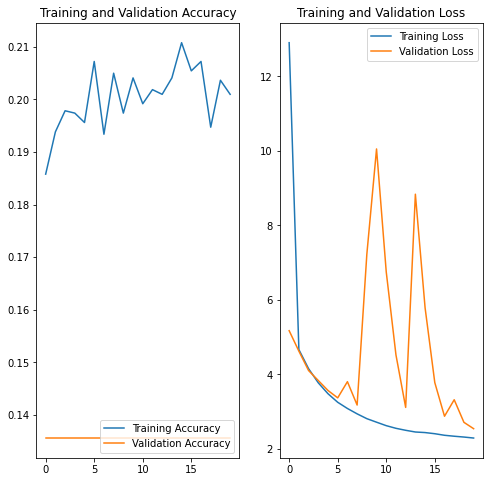

In [35]:
plot_history(history_dropouts)

### Even after adding dropout it seems it is overfitting. This can be due to the uneven distribution of data

In [ ]:
# !rm -r /content/drive/MyDrive/Colab\ Notebooks/Skin\ cancer\ ISIC\ The\ International\ Skin\ Imaging\ Collaboration/Augmented_images

In [ ]:
!pip install Augmentor

In [ ]:
path_to_training_dataset=f"{root_path}/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
    p.flip_left_right(probability=0.2)
    p.flip_top_bottom(probability=0.2)
    #p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)
    p.sample(1000) ## We are adding 1000 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/1000 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC284291BE0>: 100%|██████████| 1000/1000 [00:33<00:00, 29.78 Samples/s]
Executing Pipeline:   0%|          | 0/1000 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC273392160>: 100%|██████████| 1000/1000 [00:32<00:00, 30.74 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC2735DDDD8>:   0%|          | 1/1000 [00:00<02:11,  7.62 Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC27D696320>: 100%|██████████| 1000/1000 [00:33<00:00, 30.27 Samples/s]
Executing Pipeline:   0%|          | 0/1000 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FC284176E48>: 100%|██████████| 1000/1000 [02:22<00:00,  7.00 Samples/s]
Executing Pipeline:   0%|          | 0/1000 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x7FC270382A58>: 100%|██████████| 1000/1000 [02:01<00:00,  8.22 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC2735472E8>:   0%|          | 1/1000 [00:00<02:39,  6.28 Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC210429C88>: 100%|██████████| 1000/1000 [00:33<00:00, 29.68 Samples/s]
Executing Pipeline:   0%|          | 0/1000 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FC28420E048>: 100%|██████████| 1000/1000 [01:07<00:00, 14.82 Samples/s]
Executing Pipeline:   0%|          | 0/1000 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC2124E8400>: 100%|██████████| 1000/1000 [00:33<00:00, 30.10 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC273363E48>:   0%|          | 2/1000 [00:00<01:03, 15.70 Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC27C34D860>: 100%|██████████| 1000/1000 [00:32<00:00, 30.31 Samples/s]


In [ ]:
# data_dir_train = pathlib.Path(path_to_training_dataset)

In [ ]:

# image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
# print(image_count_train)

In [ ]:
!mkdir /content/drive/MyDrive/Colab\ Notebooks/Skin\ cancer\ ISIC\ The\ International\ Skin\ Imaging\ Collaboration/Augmented_images

In [ ]:
for class_name in class_names:
  os.rename(f"{root_path}/Train/{class_name}/output",f"{root_path}/Augmented_images/{class_name}")

In [36]:
label_dist = []
for class_name in class_names:
  label_dist.append((class_name,len([name for name in os.listdir(f"{root_path}/Augmented_images/{class_name}")])))

In [37]:
label_dist

[('actinic keratosis', 1000),
 ('basal cell carcinoma', 1000),
 ('dermatofibroma', 1000),
 ('melanoma', 1000),
 ('nevus', 1000),
 ('pigmented benign keratosis', 1000),
 ('seborrheic keratosis', 1000),
 ('squamous cell carcinoma', 1000),
 ('vascular lesion', 1000)]

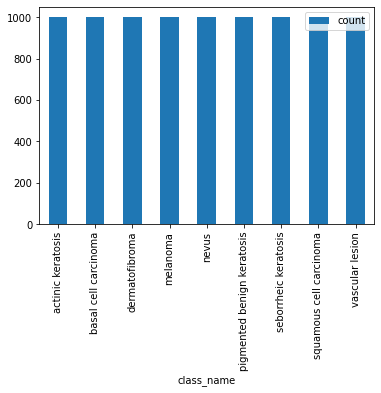

In [38]:
pd.DataFrame(label_dist,columns=['class_name','count']).plot.bar(x='class_name', y='count')

### Now all the classes have been resampled and the class distribution is same for all

In [39]:
# data_dir_train

In [40]:
train_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
  f"{root_path}/Augmented_images",
  seed=123,
  validation_split = 0.4,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode = 'categorical')

Found 9000 files belonging to 9 classes.
Using 5400 files for training.


In [41]:
train_ds_aug.class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [42]:
val_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
  f"{root_path}/Augmented_images",
  seed=123,
  validation_split = 0.4,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode = 'categorical')

Found 9000 files belonging to 9 classes.
Using 3600 files for validation.


In [43]:
def get_model_dropouts_aug(n_classes=2):
  model = Sequential([
  # data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height, img_width, 3)),

  layers.Conv2D(16, 3, padding='same', activation='relu',kernel_initializer='he_normal'),
  layers.Conv2D(16, 3, padding='same', activation='relu',kernel_initializer='he_normal'),
  # layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu',kernel_initializer='he_normal'),#,kernel_regularizer=keras.regularizers.l2(0.01), bias_regularizer=keras.regularizers.l2(0.01)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),#,kernel_regularizer=keras.regularizers.l2(0.01), bias_regularizer=keras.regularizers.l2(0.01)),
  # layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.2),

  layers.Conv2D(64, 3, padding='same', activation='relu'),#kernel_regularizer=keras.regularizers.l2(0.01), bias_regularizer=keras.regularizers.l2(0.01)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),#kernel_regularizer=keras.regularizers.l2(0.01), bias_regularizer=keras.regularizers.l2(0.01)),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.2),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  # layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  # layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(512, activation='relu'),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(n_classes)
  ])

  return model

In [44]:
model_dropouts_aug = get_model_dropouts(n_classes)
model_dropouts_aug.compile(optimizer=optimizer,#'rmsprop',tf.keras.optimizers.SGD(),
              loss='categorical_crossentropy',#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_dropouts_aug.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 180, 180, 32)      9248      
_________________________________________________________________
dropout_5 (Dropout)          (None, 180, 180, 32)      0         
_________________________________________________________________
average_pooling2d_6 (Average (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 90, 90, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 90, 90, 64)       

In [45]:
#STEPS_PER_EPOCH = pd.DataFrame(label_dist,columns=['class_name','count1']).count1.sum()//batch_size
STEPS_PER_EPOCH = int( np.ceil(pd.DataFrame(label_dist,columns=['class_name','count1']).count1.sum()*0.6 / batch_size) )

In [46]:
history_dropouts_aug = model_dropouts_aug.fit(
  train_ds_aug,
  validation_data=val_ds_aug,
  epochs=50,
  use_multiprocessing = True,
  steps_per_epoch = STEPS_PER_EPOCH,
  callbacks = [reduce_lr]
)

Epoch 1/50
169/169 [==============================] - 2502s 14s/step - loss: 14.9101 - accuracy: 0.1292 - val_loss: 4.3561 - val_accuracy: 0.1131
Epoch 2/50
169/169 [==============================] - 66s 385ms/step - loss: 4.1194 - accuracy: 0.1251 - val_loss: 3.7107 - val_accuracy: 0.1158
Epoch 3/50
169/169 [==============================] - 66s 383ms/step - loss: 3.4431 - accuracy: 0.1487 - val_loss: 7.1015 - val_accuracy: 0.1292
Epoch 4/50
169/169 [==============================] - 66s 382ms/step - loss: 2.9791 - accuracy: 0.1850 - val_loss: 7.4402 - val_accuracy: 0.1581
Epoch 5/50
169/169 [==============================] - 66s 382ms/step - loss: 2.5986 - accuracy: 0.2987 - val_loss: 8.0442 - val_accuracy: 0.1578
Epoch 6/50
169/169 [==============================] - 66s 386ms/step - loss: 2.3687 - accuracy: 0.3415 - val_loss: 4.0595 - val_accuracy: 0.1967
Epoch 7/50
169/169 [==============================] - 66s 382ms/step - loss: 2.2197 - accuracy: 0.3817 - val_loss: 3.0195 - val_a

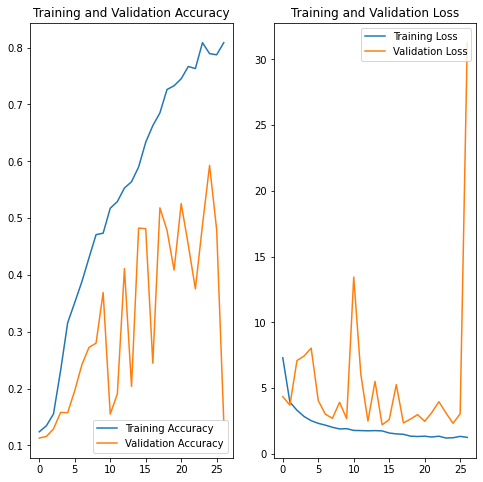

In [47]:
plot_history(history_dropouts_aug)

In [48]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  f"{root_path}/Test",
  seed=123,
  #validation_split = 0.4,
  #subset = "validation",
  image_size=(img_height, img_width),
  shuffle=False,
  # batch_size=batch_size,
  label_mode='categorical'
  )

Found 118 files belonging to 9 classes.


In [49]:
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
model_dropouts_aug.

In [58]:
model_dropouts_aug.evaluate(train_ds_aug)

169/169 [==============================] - 29s 166ms/step - loss: 1.6754 - accuracy: 0.6900


[1.6754481792449951, 0.6899999976158142]

In [59]:
model_dropouts_aug.evaluate(val_ds_aug)

113/113 [==============================] - 20s 165ms/step - loss: 3.1161 - accuracy: 0.4878


[3.116102695465088, 0.4877777695655823]

In [60]:
model_dropouts_aug.evaluate(test_ds)

4/4 [==============================] - 4s 1s/step - loss: 6.5855 - accuracy: 0.2034


[6.585516452789307, 0.20338982343673706]

In [53]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [54]:
y_actual = []
for i,class_name in enumerate(class_names):
  print(i,class_name)
  y_actual.extend([i for j in range(
      len(
        [name for name in os.listdir(f"{root_path}/Test/{class_name}")]
      )
  )
  ]
  )

y_actual = np.array(y_actual)

0 actinic keratosis
1 basal cell carcinoma
2 dermatofibroma
3 melanoma
4 nevus
5 pigmented benign keratosis
6 seborrheic keratosis
7 squamous cell carcinoma
8 vascular lesion


In [55]:
y_actual

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 8, 8, 8])

In [56]:
Y_pred = model_dropouts_aug.predict(test_ds)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_actual, y_pred))
print('Classification Report')

Confusion Matrix
[[ 1  5  3  0  5  1  0  1  0]
 [ 2  6  3  0  2  1  0  0  2]
 [ 3  4  4  1  2  1  1  0  0]
 [ 0  1  2  0 10  0  0  2  1]
 [ 0  0  5  1  8  2  0  0  0]
 [ 1  7  2  0  2  1  0  2  1]
 [ 0  2  0  1  0  0  0  0  0]
 [ 1  7  1  0  4  0  0  2  1]
 [ 0  1  0  0  0  0  0  0  2]]
Classification Report


In [57]:
print(classification_report(y_actual, y_pred))

              precision    recall  f1-score   support

           0       0.12      0.06      0.08        16
           1       0.18      0.38      0.24        16
           2       0.20      0.25      0.22        16
           3       0.00      0.00      0.00        16
           4       0.24      0.50      0.33        16
           5       0.17      0.06      0.09        16
           6       0.00      0.00      0.00         3
           7       0.29      0.12      0.17        16
           8       0.29      0.67      0.40         3

    accuracy                           0.20       118
   macro avg       0.17      0.23      0.17       118
weighted avg       0.17      0.20      0.16       118



### Even though the DEV and VAL was good for this model, it seems it is not performing quite well on test dataset

In [ ]:
def create_dense_network(n_classes,input_shape):
    model = Sequential()
    model.add(Dense())